In [1]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas
import requests
import mpmath as mp

import glob

from shapely.geometry import Point, Polygon
import contextily as ctx

import preprocessing.lst_preprocessing as prep
import preprocessing.lst_grid_preprocessing as grid

# Building data
https://osmbuildings.org/ receives XYZ tiles, so we have to calculate the tiles first out of the latitude and longitude, see https://towardsdatascience.com/map-tiles-locating-areas-nested-parent-tiles-coordinates-and-bounding-boxes-e54de570d0bd for the functions

## Conversion from latitude, longitude to tiles

In [3]:
def get_tile(lat_deg, lon_deg, zoom):
    """
    A function to get the relevant tile from lat,lon,zoom)
    """   
    lat_rad = mp.radians(lat_deg)
    n = 2 ** zoom
   
    xtile = n * ((lon_deg + 180) / 360)
    ytile = float(n * (1 - (mp.log(mp.tan(lat_rad) + mp.sec(lat_rad)) / np.pi)) / 2)
    return zoom, round(xtile), round(ytile) # 'tile %d/%d/%d '%

In [4]:
def tile2lon(z,x,y):
    return x / 2**z * 360 - 180

def tile2lat(z,x,y):
    n = mp.pi - 2 * mp.pi * y / 2**z;
    return float((180 / mp.pi) * (mp.atan(0.5 * (mp.exp(n) - mp.exp(-n)))))

def tile_bbox(z,x,y):
    '''
    Returns the lat, lon bounding box of a tile
    '''
    w = tile2lon(z,x,y)
    s = tile2lat(z,x,y) 
    e = tile2lon(z,x+1,y)
    n = tile2lat(z,x,y+1)
    return [w,s,e,n]

In [5]:
get_tile(41.393, 2.1262,15)

(15, 16578, 12238)

In [6]:
get_tile(41.393, 2.1262,15)

(15, 16578, 12238)

In [7]:
tile_bbox(*get_tile(41.393, 2.1262,15))

[2.13134765625, 41.393294288784865, 2.142333984375, 41.38505194970681]

## OSMBuildings API requests

In [8]:
def osmbuildings_request(latitude:float, longitude:float):
    """
    returns json response with building data from OSMBuildings
    API for a specific latitude and longitude
    """
    
    base_url = "https://data.osmbuildings.org/0.2/anonymous/tile"
    zoom, xtile, ytile = get_tile(latitude, longitude, 15)
    
    url = f"{base_url}/{zoom}/{xtile}/{ytile}.json"
    print(f"URL: {url}")
    headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; rv:91.0) Gecko/20100101 Firefox/91.0'}
    response = requests.get(url, headers = headers)
 
    print(f"Status code: {response.status_code}")
    json_response = response.json()

    return json_response

In [9]:
json_response = osmbuildings_request(41.39907, 2.18154)

URL: https://data.osmbuildings.org/0.2/anonymous/tile/15/16583/12237.json
Status code: 200


In [10]:
json_response['features'][10]

{'id': '653644263',
 'type': 'Feature',
 'properties': {'shape': 'none', 'height': 18, 'building': '220144969'},
 'geometry': {'type': 'Polygon',
  'coordinates': [[[2.193696, 41.39337],
    [2.193713, 41.393412],
    [2.193729, 41.393411],
    [2.193742, 41.393352],
    [2.193731, 41.393344],
    [2.193721, 41.393352],
    [2.193697, 41.39333],
    [2.193686, 41.393338],
    [2.193696, 41.39337]]]}}

In [11]:
def get_building_height(json_response):
    """
    input: json response from OSM Buildings request
    output: list of building properties (height, lat, lon)
    """
    features = json_response['features']
    height = lambda elem: elem['properties']['height']
    coords = lambda elem: elem['geometry']['coordinates'][0][0]
    
    return [[height(feature), coords(feature)] for feature in features]

In [12]:
# output format height, [lat, lon]
get_building_height(json_response)

[[12, [2.18472, 41.398911]],
 [12, [2.189303, 41.399226]],
 [9, [2.197139, 41.393681]],
 [9, [2.196101, 41.393591]],
 [3, [2.197346, 41.393648]],
 [9, [2.19681, 41.393442]],
 [9, [2.196752, 41.393395]],
 [3, [2.193837, 41.394328]],
 [2.5, [2.193499, 41.393315]],
 [18, [2.193499, 41.393315]],
 [18, [2.193696, 41.39337]],
 [12, [2.193789, 41.394501]],
 [18, [2.193754, 41.393326]],
 [18, [2.193882, 41.393279]],
 [15, [2.1947, 41.393887]],
 [18, [2.193967, 41.393343]],
 [18, [2.194052, 41.393406]],
 [18, [2.193978, 41.394457]],
 [12, [2.194013, 41.39443]],
 [18, [2.194138, 41.393469]],
 [15, [2.194063, 41.394535]],
 [18, [2.194115, 41.394354]],
 [18, [2.194223, 41.393532]],
 [12, [2.194153, 41.394737]],
 [18, [2.194308, 41.393596]],
 [18, [2.194221, 41.394715]],
 [18, [2.194216, 41.394278]],
 [18, [2.194393, 41.393659]],
 [18, [2.194306, 41.394652]],
 [18, [2.194478, 41.393722]],
 [18, [2.194391, 41.394589]],
 [18, [2.194564, 41.393785]],
 [18, [2.194476, 41.394525]],
 [18, [2.194579, 41.3

## TODO:
1. align with GPS data
2. averaging procedure
3. combine with data on used area (i.e. constructed area vs natural area): e.g. https://osmlanduse.org/#15.493044589288502/2.17254/41.40487/0/, https://data.osmlanduse.org

# Land surface temperature (LST) from satellite data

Import hd5 satelite data and convert to DataFrame

## Simple testing

In [250]:
# two different L2 files containing LST
f = h5py.File('../raw_data/London/ECOSTRESS_L2_LSTE_23097_002_20220802T145219_0601_02.h5', 'r')

# L1 fille containing GPS coordinates
geo = h5py.File('../raw_data/London/ECOSTRESS_L1B_GEO_23097_002_20220802T145219_0601_01.h5', 'r')

In [256]:
geo['Geolocation']['height'].attrs['Units']

'm'

In [14]:
def import_ECOSTRESS_data(file_path):
    return h5py.File(file_path, 'r')

In [15]:
list(import_ECOSTRESS_data('../raw_data/ECOSTRESS_L2_LSTE_22928_003_20220722T171854_0601_01.h5').keys())

FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = '../raw_data/ECOSTRESS_L2_LSTE_22928_003_20220722T171854_0601_01.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:
list(geo.keys())

['Geolocation', 'L1GEOMetadata', 'StandardMetadata']

In [ ]:
np.array(geo['Geolocation']['height'])

array([[ 49.432453,  49.434498,  49.436543, ..., 140.57167 , 161.01259 ,
        196.6524  ],
       [ 49.430782,  49.432823,  49.434868, ..., 151.71326 , 176.12303 ,
        202.03879 ],
       [ 49.429108,  49.43115 ,  49.433193, ..., 149.21332 , 172.03925 ,
        186.2959  ],
       ...,
       [ 46.972557,  46.974464,  46.976368, ..., 547.01306 , 555.8041  ,
        550.8056  ],
       [ 46.972878,  46.97478 ,  46.976685, ..., 542.969   , 548.04517 ,
        554.00757 ],
       [ 46.97319 ,  46.975094,  46.976997, ..., 529.60706 , 546.77094 ,
        554.7777  ]], dtype=float32)

In [ ]:
# acess LST
lst = f['SDS']['LST']
lst2 = f2['SDS']['LST']

# access latitude and longitude
lat, lon = geo['Geolocation']['latitude'], geo['Geolocation']['longitude']

In [ ]:
np.array(lst)[100:110,100:110]

array([[15053, 15096, 15054, 15075, 15074, 15092, 15077, 15097, 15081,
        15064],
       [15063, 15093, 15060, 15070, 15066, 15093, 15080, 15100, 15073,
        15070],
       [15072, 15081, 15072, 15081, 15054, 15094, 15090, 15090, 15074,
        15071],
       [15079, 15075, 15077, 15080, 15069, 15088, 15081, 15081, 15076,
        15070],
       [15084, 15078, 15080, 15076, 15084, 15083, 15070, 15079, 15075,
        15084],
       [15082, 15087, 15067, 15078, 15085, 15076, 15076, 15078, 15079,
        15084],
       [15074, 15091, 15070, 15078, 15088, 15077, 15079, 15079, 15093,
        15080],
       [15072, 15089, 15080, 15081, 15083, 15092, 15084, 15092, 15090,
        15088],
       [15072, 15094, 15074, 15077, 15073, 15102, 15081, 15101, 15081,
        15088],
       [15075, 15092, 15075, 15073, 15074, 15100, 15083, 15097, 15080,
        15084]], dtype=uint16)

In [ ]:
# flatten for DataFrame
lst_flat = np.array(lst).reshape(1, 5632*5400)
lat_flat = np.array(lat).reshape(1, 5632*5400)
lon_flat = np.array(lon).reshape(1, 5632*5400)

In [ ]:
# convert to Dataframe
lst_df = pd.DataFrame({'LST': lst_flat[0],
                      'Lat': lat_flat[0], 
                      'Lon': lon_flat[0]})
lst_df.sample(10)

,LST,Lat,Lon
2748553,14521,43.512153,-1.443059
28904293,15351,44.005784,2.844377
12774864,14904,43.244933,0.674730
7085441,15088,41.165680,1.736955
20492851,0,44.538082,0.746286
104684,15037,41.535480,0.139643
17290875,15086,41.404988,3.263909
24104551,15267,44.203406,1.772611
20094580,14998,42.239792,2.969658
9366396,14955,42.475351,0.855008


In [ ]:
def construct_polygon(position):
    """
    creates shapely Polygon from lat, lon
    """
    
    return Polygon(position)

In [ ]:
def get_position(lat, lon, i, j):
    """
    returns single list of 4 corners as position 
    for construct_polygon input
    """
    position = ([lon[i][j],lat[i][j]],\
                [lon[i][j+1],lat[i][j+1]],\
                [lon[i+1][j+1],lat[i+1][j+1]],\
                [lon[i+1][j],lat[i+1][j]])
    
    return position

In [ ]:
def convert2df(lst_data, lat_data, lon_data, x_lim, y_lim):
    """
    converts input data: LST, Latitude, Longitude in hd5 format with specified
    indeces in lat, lon 
    data to GeoPandas DataFrame
    """
    # access LST, multiply by 0.02 scale factor 
    # see https://ecostress.jpl.nasa.gov/downloads/psd/ECOSTRESS_SDS_PSD_L2_ver1-1.pdf
    # convert to celcius
    
    SCALE_FACTOR = 0.02
    KELVIN_CELCIUS = -273.15
    
    lst = (SCALE_FACTOR * np.array(lst_data)[x_lim[0]:x_lim[1], y_lim[0]:y_lim[1]]) + KELVIN_CELCIUS
    
    # acess latitude and longitude
    lat = np.array(lat_data)[x_lim[0]:x_lim[1], y_lim[0]:y_lim[1]]
    lon = np.array(lon_data)[x_lim[0]:x_lim[1], y_lim[0]:y_lim[1]]
    
    print(lat.shape, lat[0])

    # flatten for DataFrame
    lst_flat = lst.reshape(1, np.multiply(*lst.shape))
    lat_flat = lat.reshape(1, np.multiply(*lat.shape))
    lon_flat = lon.reshape(1, np.multiply(*lon.shape))
    
    # convert to Dataframe
    lst_df = pd.DataFrame({'LST': lst_flat[0],
                        'Lat': lat_flat[0], 
                        'Lon': lon_flat[0]})
    
    # create polygons for 70x70 m² tiles
    x_range = range(0,lon.shape[0]-1)
    y_range = range(0,lat.shape[1]-1)
    
    polygons = [construct_polygon(get_position(lat, lon, i, j)) for i in x_range for j in y_range]
   
    
    # convert to GeoPandas DataFrame
    # lst_df.iloc[:len(polygons),:] since polygons need on corner further
    gdf = geopandas.GeoDataFrame(lst_df.iloc[:len(polygons),:], geometry=polygons)#, crs = "EPSG:4326")
        
    return gdf

In [ ]:
gdf_small = convert2df(lst,lat, lon, [1000,1020], [2000,2020])
gdf_small

(20, 20) [41.82422548 41.8247524  41.82528066 41.82579168 41.82633958 41.82684542
 41.82737921 41.8279215  41.82849343 41.82907114 41.8296134  41.83010326
 41.83062558 41.83114925 41.83168924 41.83222709 41.83272269 41.83323546
 41.83375372 41.83426341]


,LST,Lat,Lon,geometry
0,26.79,41.824225,0.809180,"POLYGON ((0.80918 41.82423, 0.80865 41.82475, ..."
1,26.65,41.824752,0.808650,"POLYGON ((0.80865 41.82475, 0.80812 41.82528, ..."
2,26.99,41.825281,0.808120,"POLYGON ((0.80812 41.82528, 0.80761 41.82579, ..."
3,26.75,41.825792,0.807613,"POLYGON ((0.80761 41.82579, 0.80706 41.82634, ..."
4,27.03,41.826340,0.807060,"POLYGON ((0.80706 41.82634, 0.80655 41.82685, ..."
...,...,...,...,...
356,26.97,41.839814,0.813559,"POLYGON ((0.81535 41.83921, 0.81482 41.83974, ..."
357,26.87,41.840344,0.813030,"POLYGON ((0.81482 41.83974, 0.81431 41.84024, ..."
358,26.89,41.840869,0.812499,"POLYGON ((0.81431 41.84024, 0.81378 41.84076, ..."
359,26.83,41.841376,0.811992,"POLYGON ((0.81378 41.84076, 0.81325 41.84129, ..."


## With functions from preprocessing.lst_preprocessing

In [296]:
from ast import literal_eval

In [297]:
gdf_Paris_import = pd.read_csv('../processed_data/Paris.csv',\
    dtype={'LST':np.float32, 'LST_diff':np.float32, \
        'elevation':np.float32, 'elevation_diff':np.float32})
gdf_Paris_import.sample(2)

,LST,elevation,LST_diff,elevation_diff,ul_corner,ll_corner,lr_corner,ur_corner,geometry
17393,34.609985,54.907166,3.804016,-18.854477,"[[2.266474177669119, 48.85665039212117]]","[[2.266474177669119, 48.85727995835752]]","[[2.267103743905472, 48.85727995835752]]","[[2.267103743905472, 48.85665039212117]]","POLYGON ((2.266474177669119 48.85665039212117,..."
4061,26.149994,49.342583,-4.655975,-24.419060,"[[2.2815837673415897, 48.82328338159446]]","[[2.2815837673415897, 48.82391294783081]]","[[2.2822133335779426, 48.82391294783081]]","[[2.2822133335779426, 48.82328338159446]]",POLYGON ((2.2815837673415897 48.82328338159446...


In [304]:
gdf_Paris_import['ul_corner'].apply(lambda x: np.float32(x.strip("[]").split(", ")))[0]

array([ 2.2633264, 48.81321  ], dtype=float32)

In [306]:
gdf_Paris_import['geometry'].apply(literal_eval)[0]

SyntaxError: invalid syntax. Perhaps you forgot a comma? (<unknown>, line 1)

In [294]:
# gdf_Paris_import.loc[:,['ul_corner','ll_corner','lr_corner','ur_corner']].set_d
gdf_Paris_import.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35028 entries, 0 to 35027
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   LST             35028 non-null  float32
 1   elevation       35028 non-null  float32
 2   LST_diff        35028 non-null  float32
 3   elevation_diff  35028 non-null  float32
 4   ul_corner       35028 non-null  object 
 5   ll_corner       35028 non-null  object 
 6   lr_corner       35028 non-null  object 
 7   ur_corner       35028 non-null  object 
 8   geometry        35028 non-null  object 
dtypes: float32(4), object(5)
memory usage: 1.9+ MB


In [290]:
gdf_Paris_import['ul_corner'][0]

'[[2.2633263464873545, 48.81321032181281]]'

In [278]:
geopandas.GeoDataFrame(gdf_Paris_import.drop(columns='geometry'), geometry=gdf_Paris_import['geometry'])

TypeError: Input must be valid geometry objects: POLYGON ((2.2633263464873545 48.81321032181281, 2.2633263464873545 48.813839888049166, 2.2639559127237074 48.813839888049166, 2.2639559127237074 48.81321032181281, 2.2633263464873545 48.81321032181281))

In [16]:
 city_name = "London"
 df = prep.convert2df_coord(*prep.import_city_data(city_name),*prep.CITY_BOUNDING_BOXES[city_name])
 df.head(10)

,LST,Latitude,Longitude,height,LST_Difference,height_Difference
0,17.230011,51.469460,-0.215520,54.856796,-7.661585,-66.131149
1,17.989990,51.470215,-0.215993,58.094570,-6.901606,-62.893375
2,16.630005,51.469730,-0.214343,48.727318,-8.261591,-72.260628
3,17.750000,51.470474,-0.214803,54.617947,-7.141596,-66.369995
4,18.489990,51.471260,-0.215315,49.401390,-6.401606,-71.586555
5,20.109985,51.472015,-0.215786,52.828224,-4.781610,-68.159721
6,21.750000,51.472778,-0.216270,53.543209,-3.141596,-67.444733
7,16.609985,51.469227,-0.212649,53.278511,-8.281610,-67.709435
8,16.850006,51.469959,-0.213114,53.670322,-8.041590,-67.317627
9,17.790009,51.470726,-0.213600,53.753899,-7.101587,-67.234047


In [17]:
df_London = pd.read_csv('../processed_data/London.csv')
df_London.head(10)

,LST,Latitude,Longitude,height,LST_Difference,height_Difference
0,17.23,51.469460,-0.215520,54.856796,-11.087025,-66.145340
1,17.99,51.470214,-0.215993,58.094570,-10.327025,-62.907566
2,16.63,51.469732,-0.214343,48.727318,-11.687025,-72.274818
3,17.75,51.470475,-0.214803,54.617947,-10.567025,-66.384186
4,18.49,51.471262,-0.215315,49.401390,-9.827025,-71.600746
5,20.11,51.472015,-0.215786,52.828224,-8.207025,-68.173912
6,21.75,51.472779,-0.216270,53.543209,-6.567025,-67.458923
7,16.61,51.469227,-0.212649,53.278511,-11.707025,-67.723625
8,16.85,51.469959,-0.213114,53.670322,-11.467025,-67.331818
9,17.79,51.470725,-0.213600,53.753899,-10.527025,-67.248238


## Resample swath to grid

In [ ]:
# ! pip install pyresample

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 3.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.7/60.7 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached PyYAML-6.0-cp310-cp310-macosx_10_9_x86_64.whl (197 kB)
  DEPRECATION: configobj is being installed using the legacy 'setup.py install' method, because it does not have a 'pyproject.toml' and the 'wheel' package is not installed. pip 23.1 will enforce this behaviour change. A possible replacement is to enable the '--use-pep517' option. Discussion can be found at https://github.com/pypa/pip/issues/8559
  Running setup.py install for configobj ... done


In [ ]:
from pyresample import geometry as geom
from pyresample import kd_tree as kdt
import pyproj

In [18]:
lst_data, lat_data, lon_data, height_data = prep.import_city_data('Paris')
lat_data.shape

(5632, 5400)

In [ ]:
def swath_to_grid(lst_data: np.array, 
                  lon_data: np.array,
                  lat_data: np.array):#,height_data :np.array):
    """
    converts satellite swath to regular grid
    based upon: https://git.earthdata.nasa.gov/projects/LPDUR/repos/tutorial-ecostress/browse/ECOSTRESS_Tutorial.ipynb
    """
    # pixel size
    PIXEL_SIZE = 70
    
    # Set swath definition from lat/lon arrays
    swath_def= geom.SwathDefinition(lons=lon_data, lats=lat_data)
   
    #Define the coordinates in the middle of the swath, which are used 
    # to calculate an estimate of the output rows/columns for the gridded output.
    mid = [int(lat_data.shape[1] / 2) - 1, int(lat_data.shape[0] / 2) - 1]
    mid_lat, mid_lon = lat_data[mid[0]][mid[1]], lon_data[mid[0]][mid[1]]

    # Define AEQD projection centered at swath center
    epsg_convert = pyproj.Proj("+proj=aeqd +lat_0={} +lon_0={}".format(mid_lat, mid_lon))

    # Use info from AEQD projection bbox to calculate output cols/rows/pixel size
    ll_lon, ll_lat = epsg_convert(np.min(lon_data), np.min(lat_data), inverse=False)
    ur_lon, ur_lat = epsg_convert(np.max(lon_data), np.max(lat_data), inverse=False)
    area_extent = (ll_lon, ll_lat, ur_lon, ur_lat)
    
    cols = int(round((area_extent[2] - area_extent[0]) / PIXEL_SIZE))  # 70 m pixel size
    rows = int(round((area_extent[3] - area_extent[1]) / PIXEL_SIZE)) 
    
    #Use number of rows and columns generated above from the AEQD projection
    # to set a representative number of rows and columns in the Geographic area definition, 
    # which will then be translated to degrees below, then take the smaller
    # of the two pixel dims to determine output size and ensure square pixels.

    # Define Geographic projection
    epsg, proj, proj_name = '4326', 'longlat', 'Geographic'

    # Define bounding box of swath
    ll_lon, ll_lat, ur_lon, ur_lat = np.min(lon_data), np.min(lat_data), np.max(lon_data), np.max(lat_data)
    area_extent = (ll_lon, ll_lat, ur_lon, ur_lat)

    # Create area definition with estimated number of columns and rows
    proj_dict = pyproj.CRS("epsg:4326")
    area_def = geom.AreaDefinition(epsg, proj_name, proj, proj_dict, cols, rows, area_extent)
    
    # Square pixels and calculate output cols/rows
    pixel_size = np.min([area_def.pixel_size_x, area_def.pixel_size_y])
    cols = int(round((area_extent[2] - area_extent[0]) / pixel_size))
    rows = int(round((area_extent[3] - area_extent[1]) / pixel_size))

    # Set up a new Geographic area definition with the refined cols/rows
    area_def = geom.AreaDefinition(epsg, proj_name, proj, proj_dict, cols, rows, area_extent)
    
    # Get arrays with information about the nearest neighbor to each grid point
    # function is comparing the swath and area definitions 
    # to locate the nearest neighbor (neighbours=1). 
    # 210 is the radius_of_influence, or the radius used to search for the nearest 
    # neighboring pixel in the swath (in meters).
    index, outdex, index_array, dist_array = kdt.get_neighbour_info(swath_def, area_def, 210, neighbours=1)
    
 
    # The second step is to use those arrays to retrieve a resampled result.
    # Perform K-D Tree nearest neighbor resampling (swath 2 grid conversion)
    lst_grid = kdt.get_sample_from_neighbour_info('nn', area_def.shape, lst_data, index,\
                                                  outdex, index_array, fill_value=0)
    
    # ToDo: height_data 
    
    # Define the geotransform: lower_left latitude, longitude, pixel_size
    geo_transform = [area_def.area_extent[0], area_def.area_extent[1], pixel_size]
    
    return lst_grid, geo_transform

In [ ]:
lst_gridded = swath_to_grid(lst_data, lon_data, lat_data)

In [ ]:
lst_gridded[1]

[-3.0244005, 47.516933, 0.0006295662363529403]

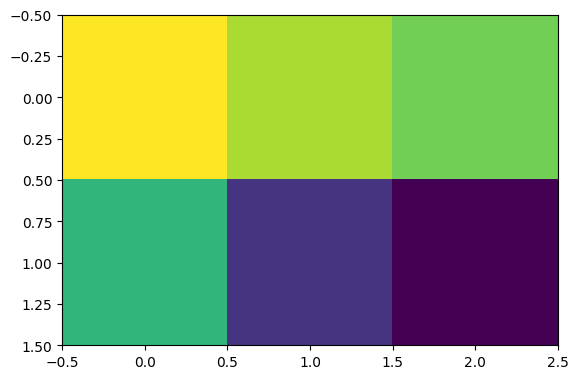

In [71]:
plt.imshow(lst_gridded[0][5000:5002,7000:7003])

In [21]:
def get_pixel_coords(row_col: list, geo_transform: list) -> list:
    """
    returs list of corner coordinates lat, lon of pixel 
    for specific row and column
    format: [upper_left, lower_left, lower_right, upper_right]
    """
    pixel_size = geo_transform[-1]
    row = row_col[0]
    col = row_col[1]
    
    current_row = geo_transform[1] + pixel_size * (row - 1)
    next_row = current_row + pixel_size
    
    current_col = geo_transform[0] + pixel_size * (col - 1)
    next_col = current_col + pixel_size
    
    upper_left = [current_row, current_col]
    lower_left = [next_row, current_col]
    lower_right = [next_row, next_col]
    upper_right = [current_row, next_col]
  
    return [upper_left, lower_left, lower_right, upper_right]

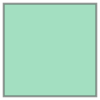

In [ ]:
Polygon(get_pixel_coords((0,2),geo_transform=lst_gridded[1]))

In [ ]:
get_pixel_coords_vec = np.vectorize(get_pixel_coords)

In [22]:
get_pixel_coords((3,2),geo_transform=lst_gridded[1])

[[47.51819257363481, -3.0237709064046383],
 [47.51882213987117, -3.0237709064046383],
 [47.51882213987117, -3.0231413401682854],
 [47.51819257363481, -3.0231413401682854]]

In [25]:
lst_gridded[1]

[-3.0244005, 47.516933, 0.0006295662363529403]

In [60]:
def coord_bounds_to_pixels(geo_transform, bounds):
    """
    converts coordinate bounds in lon, lat format
    to pixel bounds in lon, lat format
    """
    pixel_size = geo_transform[-1]
    
    lon_start = round((bounds[0][0]-geo_transform[0])/pixel_size)
    lon_end = round((bounds[0][1]-geo_transform[0])/pixel_size)

    lat_start = round((bounds[1][0]-geo_transform[1])/pixel_size)
    lat_end = round((bounds[1][1]-geo_transform[1])/pixel_size)

    return lon_start,lon_end + 1, lat_start, lat_end + 1

In [61]:
coord_bounds_to_pixels(lst_gridded[1], prep.CITY_BOUNDING_BOXES['Paris'])

(8400, 8652, 2060, 2199)

In [67]:
lst_gridded[0][2060:2199, 8400:8652].shape

(139, 252)

In [128]:
def build_gdf(lst_data_grid, geo_transform, city):
    """
    build GeoDataFrame
    """
    
    # pixel bounds
    lon_bounds = coord_bounds_to_pixels(geo_transform, prep.CITY_BOUNDING_BOXES[city])[:2]
    lat_bounds = coord_bounds_to_pixels(geo_transform, prep.CITY_BOUNDING_BOXES[city])[2:]
    
    # pixel ranges
    lon_range = np.arange(*lon_bounds)
    lat_range = np.arange(*lat_bounds)
    
    # slice data
    lst_slice = lst_data_grid[lat_bounds[0]:lat_bounds[1], lon_bounds[0]:lon_bounds[1]]
    # height data
    
    # corner coordinates
    corners = np.array([[get_pixel_coords((row, col), geo_transform) \
        for col in lon_range] for row in lat_range])
    
    # flatten
    lst_flat = lst_slice.reshape(np.multiply(*lst_slice.shape), )
    corners_flat = corners.reshape(np.multiply(*corners.shape[:2]),*corners.shape[2:])

    # build shapely polygons
    polygons = [Polygon(single_corners) for single_corners in corners_flat]
    
    # GeoDataFrame
    gpd = geopandas.GeoDataFrame(lst_flat.T, geometry = polygons)
    gpd.columns = ['LST', 'geometry']
    
    return gpd

In [129]:
build_gdf(lst_gridded[0], lst_gridded[1], "London")

,LST,geometry
0,15082.0,"POLYGON ((48.81321 2.26333, 48.81384 2.26333, ..."
1,15085.0,"POLYGON ((48.81321 2.26396, 48.81384 2.26396, ..."
2,15080.0,"POLYGON ((48.81321 2.26459, 48.81384 2.26459, ..."
3,15119.0,"POLYGON ((48.81321 2.26522, 48.81384 2.26522, ..."
4,15052.0,"POLYGON ((48.81321 2.26584, 48.81384 2.26584, ..."
...,...,...
35023,15365.0,"POLYGON ((48.90009 2.41883, 48.90072 2.41883, ..."
35024,15345.0,"POLYGON ((48.90009 2.41946, 48.90072 2.41946, ..."
35025,15345.0,"POLYGON ((48.90009 2.42009, 48.90072 2.42009, ..."
35026,15292.0,"POLYGON ((48.90009 2.42072, 48.90072 2.42072, ..."


In [286]:
gdf_Paris = grid.create_gdf("Paris")

In [321]:
gdf_Paris_export = geopandas.GeoDataFrame({'LST':gdf_Paris['LST'],
                                           'ul':gdf_Paris['ul_corner'].apply(lambda x: str(x))}, geometry=gdf_Paris['geometry'])

In [322]:
gdf_Paris_export

,LST,ul,geometry
0,28.489990,"[[2.2633263464873545, 48.81321032181281]]","POLYGON ((2.26333 48.81321, 2.26333 48.81384, ..."
1,28.549988,"[[2.2639559127237074, 48.81321032181281]]","POLYGON ((2.26396 48.81321, 2.26396 48.81384, ..."
2,28.450012,"[[2.2645854789600603, 48.81321032181281]]","POLYGON ((2.26459 48.81321, 2.26459 48.81384, ..."
3,29.230011,"[[2.2652150451964133, 48.81321032181281]]","POLYGON ((2.26522 48.81321, 2.26522 48.81384, ..."
4,27.889984,"[[2.265844611432766, 48.81321032181281]]","POLYGON ((2.26584 48.81321, 2.26584 48.81384, ..."
...,...,...,...
35023,34.149994,"[[2.4188292068665307, 48.90009046242952]]","POLYGON ((2.41883 48.90009, 2.41883 48.90072, ..."
35024,33.750000,"[[2.4194587731028836, 48.90009046242952]]","POLYGON ((2.41946 48.90009, 2.41946 48.90072, ..."
35025,33.750000,"[[2.4200883393392365, 48.90009046242952]]","POLYGON ((2.42009 48.90009, 2.42009 48.90072, ..."
35026,32.690002,"[[2.4207179055755894, 48.90009046242952]]","POLYGON ((2.42072 48.90009, 2.42072 48.90072, ..."


In [325]:
gdf_Paris_export.to_file("../processed_data/Paris.shp")

In [327]:
gdf_Paris_reimport = geopandas.read_file('../processed_data/Paris.shp')

<AxesSubplot: >

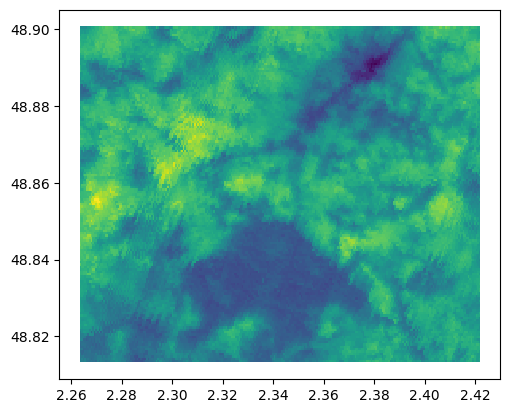

In [329]:
gdf_Paris_reimport.plot(column='LST')

In [307]:
gdf_Paris.sample(5)

,LST,elevation,LST_diff,elevation_diff,ul_corner,ll_corner,lr_corner,ur_corner,geometry
21211,32.829987,52.271267,2.024017,-21.490376,"[[2.2903976946505304, 48.86609388566646]]","[[2.2903976946505304, 48.866723451902814]]","[[2.2910272608868834, 48.866723451902814]]","[[2.2910272608868834, 48.86609388566646]]","POLYGON ((2.29040 48.86609, 2.29040 48.86672, ..."
29629,29.510010,71.066818,-1.295959,-2.694824,"[[2.3546134507585306, 48.88686957146611]]","[[2.3546134507585306, 48.88749913770246]]","[[2.3552430169948835, 48.88749913770246]]","[[2.3552430169948835, 48.88686957146611]]","POLYGON ((2.35461 48.88687, 2.35461 48.88750, ..."
20650,32.109985,81.843002,1.304016,8.081360,"[[2.4131631107393536, 48.8642051869574]]","[[2.4131631107393536, 48.864834753193755]]","[[2.4137926769757065, 48.864834753193755]]","[[2.4137926769757065, 48.8642051869574]]","POLYGON ((2.41316 48.86421, 2.41316 48.86483, ..."
26492,32.950012,87.229141,2.144043,13.467499,"[[2.2834724660506485, 48.87931477662987]]","[[2.2834724660506485, 48.879944342866224]]","[[2.2841020322870014, 48.879944342866224]]","[[2.2841020322870014, 48.87931477662987]]","POLYGON ((2.28347 48.87931, 2.28347 48.87994, ..."
20413,30.070007,76.584595,-0.735962,2.822952,"[[2.2639559127237074, 48.8642051869574]]","[[2.2639559127237074, 48.864834753193755]]","[[2.2645854789600603, 48.864834753193755]]","[[2.2645854789600603, 48.8642051869574]]","POLYGON ((2.26396 48.86421, 2.26396 48.86483, ..."


In [249]:
((gdf_Paris.LST.mean(), gdf_Paris.elevation.mean()),\
(gdf_Paris.LST_diff.mean(), gdf_Paris.elevation_diff.mean()),\
(gdf_Paris.LST.min(), gdf_Paris.elevation.min()),\
(gdf_Paris.LST.max(), gdf_Paris.elevation.max()))

((30.80597, 73.76164),
 (-1.2545767e-06, -4.181922e-06),
 (19.070007, 45.57731),
 (41.329987, 135.38147))

In [154]:
((gdf_Paris.LST.mean(), gdf_Paris.elevation.mean()),\
(gdf_Paris.LST.min(), gdf_Paris.elevation.min()),\
(gdf_Paris.LST.max(), gdf_Paris.elevation.max()))

((30.80597, 73.76164), (19.070007, 45.57731), (41.329987, 135.38147))

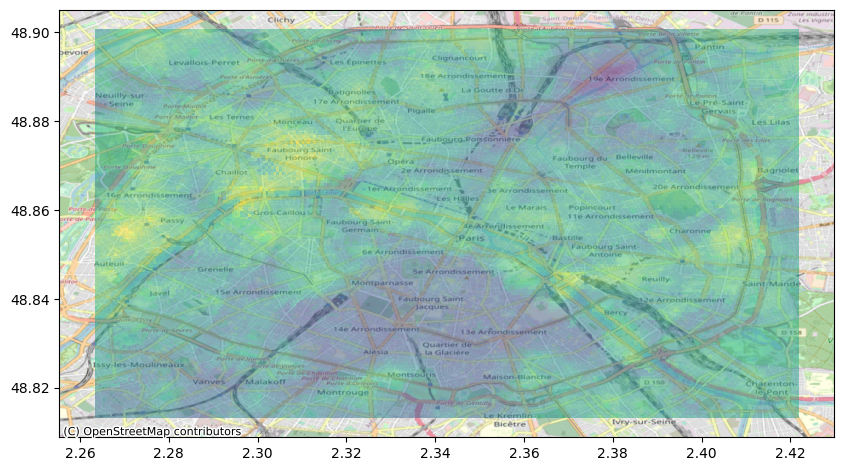

In [245]:
fig, ax = plt.subplots(figsize = (10,15))
gdf_Paris.plot(column = 'LST', ax = ax, alpha = .5)
ctx.add_basemap(ax,  crs='EPSG:4326', source=ctx.providers.OpenStreetMap.Mapnik)

In [19]:
lst_data, lat_data, lon_data, height_data = prep.import_city_data('Paris')
lst_gridded = grid.swath_to_grid(lst_data, lon_data, lat_data)

## Getting correct bounding box coordinates

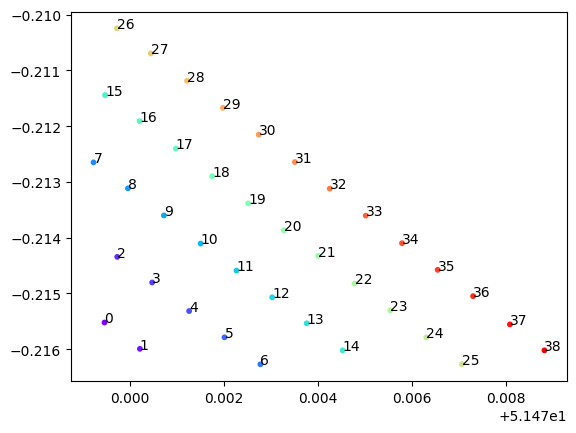

In [ ]:
number_points = 39

colors = cm.rainbow(np.linspace(0, 1, number_points))
lat_x = df_London['Latitude'][:number_points]
lon_x = df_London['Longitude'][:number_points]

fig, ax = plt.subplots()

ax.scatter(lat_x, lon_x, s=10, c = colors)
for i in range(number_points):
    ax.annotate(i, (lat_x[i], lon_x[i]))

In [ ]:
def get_closest_point(latitude: float, lat_data: pd.DataFrame):
    """
    returns closest latitude inside lat_data for 
    initial latitude point
    """
    
    
    

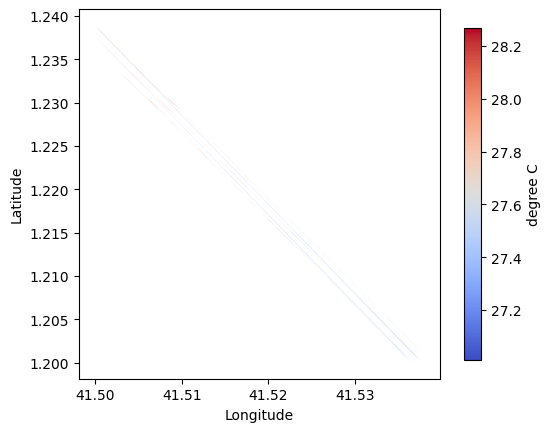

In [ ]:
gdf_coord.loc[1000:1200,:].plot(column = 'LST', cmap = 'coolwarm', legend=True, legend_kwds={'shrink': 0.9, 'label': 'degree C'})
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

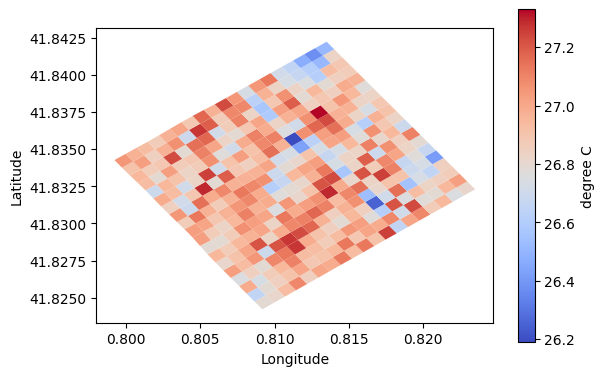

In [ ]:
gdf_small.plot(column = 'LST', cmap = 'coolwarm', legend=True, legend_kwds={'shrink': 0.9, 'label': 'degree C'})
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

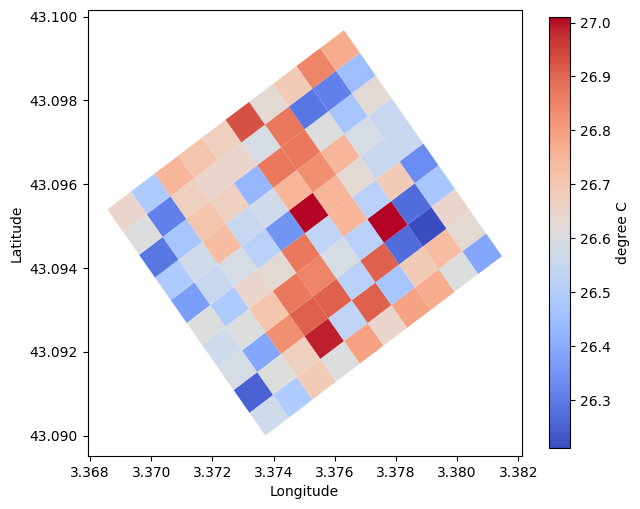

In [ ]:
fig, ax = plt.subplots(figsize = (7,7))

convert2df(lst,lat, lon, [5000,5011],[2000,2011]).plot(column = 'LST', cmap = 'coolwarm',\
    legend = True,legend_kwds={'shrink': 0.8, 'label': 'degree C'},ax=ax)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

plt.show()

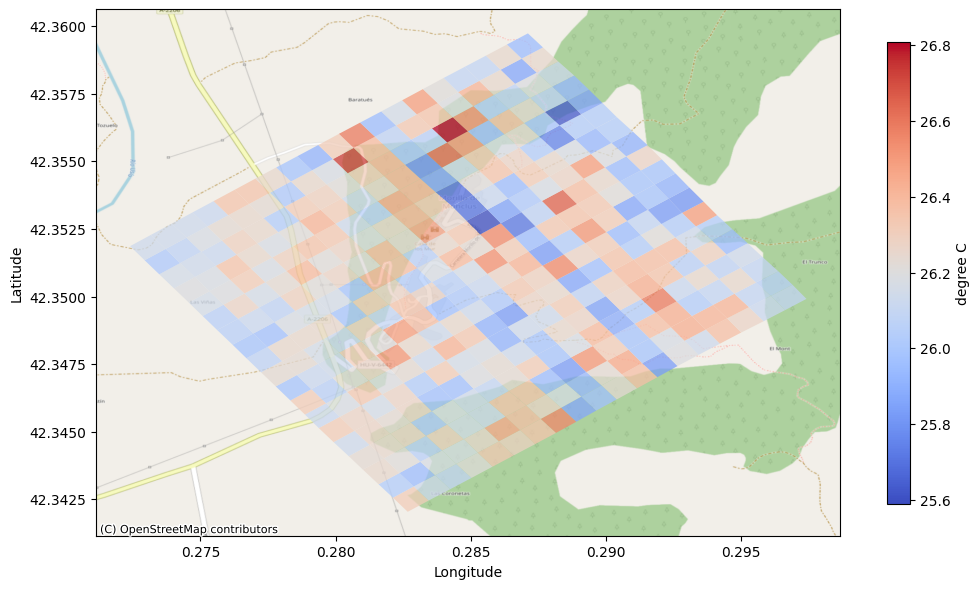

In [ ]:
fig, ax = plt.subplots(figsize = (12,12))
convert2df(lst,lat, lon, [1000,1020], [3000,3020]).plot(column = 'LST', cmap = 'coolwarm',\
    legend = True,legend_kwds={'shrink': 0.5, 'label': 'degree C'},alpha = .75, ax = ax)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

ctx.add_basemap(ax, crs='EPSG:4326', source=ctx.providers.OpenStreetMap.Mapnik)

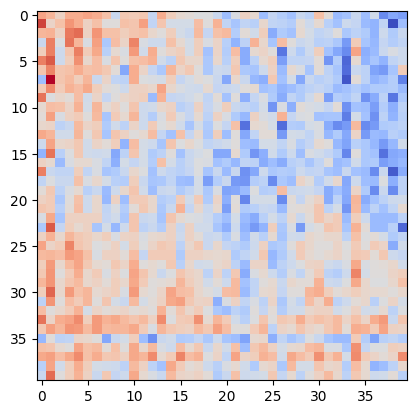

In [ ]:
# sample plot
plt.imshow(np.array(lst)[2000:2040,2000:2040], cmap = 'coolwarm')

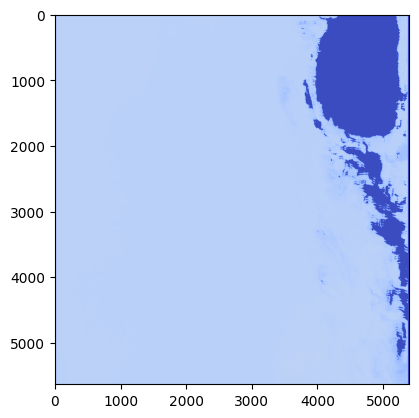

In [ ]:
plt.imshow(np.array(lst), cmap = 'coolwarm')

## TODO:
1. align with GPS data
2. plotting on map
3. averaging procedure?

# Further geographical-building data: Ohsome API
Docu: https://docs.ohsome.org/ohsome-api/v1/index.html <br>
Examples: https://docs.ohsome.org/ohsome-api/v1/filter.html#examples

In [ ]:
# total area
URL = 'https://api.ohsome.org/v1/elements/area'
data = {"bboxes": "8.625,49.3711,8.7334,49.4397", "format": "json", "time": "2014-01-01", "filter": "landuse=farmland"}
response = requests.post(URL, data=data)
print(response.json())

{'attribution': {'url': 'https://ohsome.org/copyrights', 'text': '© OpenStreetMap contributors'}, 'apiVersion': '1.8.0', 'result': [{'timestamp': '2014-01-01T00:00:00Z', 'value': 10242756.68}]}


In [ ]:
# density
URL = 'https://api.ohsome.org/v1/elements/count/density'
data = {"bboxes": "8.625,49.3711,8.7334,49.4397", "format": "json", "time": "2019-05-07", "filter": "landuse=farmland"}
response = requests.post(URL, data=data)
print(response.json())

{'attribution': {'url': 'https://ohsome.org/copyrights', 'text': '© OpenStreetMap contributors'}, 'apiVersion': '1.8.0', 'result': [{'timestamp': '2019-05-07T00:00:00Z', 'value': 5.9}]}


In [ ]:
# 41.4043, 2.18345, 41.40426, 2.18776
data = {"bboxes": "2.18345,41.4043,2.18776,41.40426", "format": "json", "time": "2019-05-07", "filter": "landuse=residential"}
response = requests.post(URL, data=data)
print(response.json())

{'attribution': {'url': 'https://ohsome.org/copyrights', 'text': '© OpenStreetMap contributors'}, 'apiVersion': '1.8.0', 'result': [{'timestamp': '2019-05-07T00:00:00Z', 'value': 0.0}]}


In [ ]:
# geometry
URL = 'https://api.ohsome.org/v1/contributions/geometry'
data = {"bboxes": "8.6720,49.3988,8.7026,49.4274", "time": "2020-02-01,2020-06-29", "filter": "landuse=farmland"}
response = requests.post(URL, data=data)
print(response.json())

{'attribution': {'url': 'https://ohsome.org/copyrights', 'text': '© OpenStreetMap contributors'}, 'apiVersion': '1.8.0', 'type': 'FeatureCollection', 'features': [{'type': 'Feature', 'geometry': {'type': 'Polygon', 'coordinates': [[[8.6768983, 49.4251524], [8.6772148, 49.4246729], [8.6771852, 49.4246671], [8.6766461, 49.4245684], [8.6765662, 49.4247096], [8.675516, 49.4245251], [8.6754856, 49.4245859], [8.6757673, 49.4248258], [8.675901, 49.4249687], [8.6768983, 49.4251524]]]}, 'properties': {'@contributionChangesetId': 86062107, '@osmId': 'way/283940872', '@timestamp': '2020-06-01T20:08:25Z'}}]}


# Elevation data

From: https://api.open-elevation.com/

In [ ]:
base_url = "https://api.open-elevation.com/api/v1/lookup?locations"
coords = [41.161758,-8.583933] #lat, lon
params = {'locations':','.join([str(i) for i in coords])}

response = requests.get(base_url, params=params)
print(f'status: {response.status_code}')
print(f'url: {response.url}')
response.json()

status: 200
url: https://api.open-elevation.com/api/v1/lookup?locations&locations=41.161758%2C-8.583933


{'results': [{'latitude': 41.161758,
   'longitude': -8.583933,
   'elevation': 117}]}

# Further testing

In [ ]:
lst_df_short = lst_df.loc[2000:4000,:]

In [ ]:
gdf = geopandas.GeoDataFrame(
    lst_df_short, geometry=geopandas.points_from_xy(lst_df_short.Lon, lst_df_short.Lat))

gdf.head(7)

,LST,Lat,Lon,geometry
2000,15036,41.483136,0.170243,POINT (0.17024 41.48314)
2001,15031,41.483658,0.169708,POINT (0.16971 41.48366)
2002,15027,41.484182,0.169174,POINT (0.16917 41.48418)
2003,15031,41.484685,0.168663,POINT (0.16866 41.48468)
2004,15031,41.485228,0.168105,POINT (0.16810 41.48523)
2005,15029,41.485730,0.167593,POINT (0.16759 41.48573)
2006,15038,41.486246,0.167056,POINT (0.16706 41.48625)


In [ ]:
type(gdf)

geopandas.geodataframe.GeoDataFrame

<AxesSubplot:>

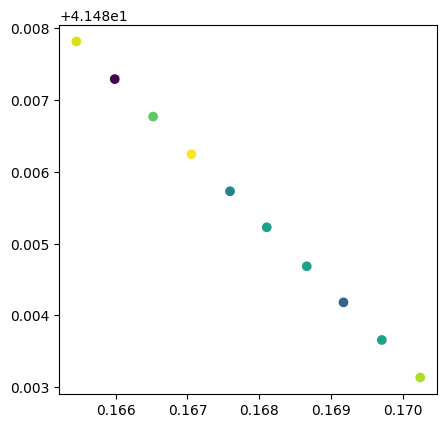

In [ ]:
gdf.iloc[:10,:].plot(column = 'LST', k=9)

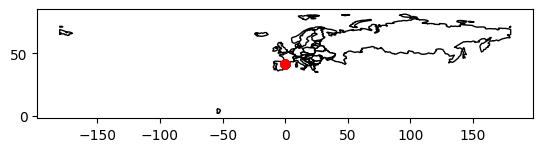

In [ ]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

# We restrict to South America.
ax = world[world.continent == 'Europe'].plot(
    color='white', edgecolor='black')

# We can now plot our ``GeoDataFrame``.
gdf.plot(ax=ax, color='red')

plt.show()

In [ ]:
import shapely

In [ ]:
# couldn't find belgrade geometry, used osmnx and simplified geometry as a WKT string
belgrade_poly = shapely.wkt.loads(
    "POLYGON ((20.2213764 44.9154621, 20.2252450 44.9070062, 20.2399466 44.9067193, 20.2525385 44.8939145, 20.2419942 44.8842235, 20.2610016 44.8826597, 20.2794675 44.8754192, 20.2858284 44.8447802, 20.2856918 44.8332410, 20.3257447 44.8342507, 20.3328068 44.8098272, 20.3367239 44.8080890, 20.3339619 44.8058144, 20.3353253 44.8011005, 20.3336310 44.8003791, 20.3360230 44.7898245, 20.3384687 44.7907875, 20.3405086 44.7859144, 20.3417344 44.7872272, 20.3474466 44.7713203, 20.3509860 44.7687822, 20.3398029 44.7558716, 20.3220093 44.7448572, 20.3160895 44.7387338, 20.3235092 44.7345531, 20.3359605 44.7308053, 20.3437350 44.7301552, 20.3450306 44.7243651, 20.3497410 44.7209764, 20.3521450 44.7143627, 20.3633795 44.7046060, 20.3830709 44.7030441, 20.3845248 44.7011631, 20.3847991 44.7032182, 20.3924066 44.7036702, 20.4038881 44.6984458, 20.4097684 44.6992834, 20.4129839 44.7024603, 20.4192098 44.7021308, 20.4217436 44.7034920, 20.4251744 44.6976337, 20.4279418 44.6980838, 20.4313251 44.6940680, 20.4358368 44.6933579, 20.4402665 44.6905161, 20.4452138 44.6910160, 20.4495428 44.6880459, 20.4539572 44.6888231, 20.4529809 44.6911331, 20.4550753 44.6919188, 20.4534174 44.6929137, 20.4571253 44.6957696, 20.4570013 44.7008391, 20.4614601 44.7027894, 20.4646634 44.7018970, 20.4674388 44.7050131, 20.4753542 44.7039532, 20.4760757 44.7050260, 20.4802055 44.7033479, 20.4867635 44.7061539, 20.4983359 44.7022445, 20.5049892 44.7021663, 20.5071809 44.7071295, 20.5027682 44.7154832, 20.5028502 44.7217294, 20.5001912 44.7225288, 20.5007294 44.7251513, 20.5093727 44.7271542, 20.5316662 44.7248060, 20.5385861 44.7270519, 20.5390058 44.7329843, 20.5483761 44.7280993, 20.5513810 44.7308508, 20.5510751 44.7340860, 20.5483958 44.7345580, 20.5503614 44.7352316, 20.5509440 44.7434333, 20.5416617 44.7521169, 20.5358563 44.7553171, 20.5348919 44.7609694, 20.5393015 44.7624855, 20.5449353 44.7698750, 20.5490005 44.7708792, 20.5488362 44.7733456, 20.5647717 44.7649237, 20.5711431 44.7707818, 20.5772388 44.7711074, 20.5798915 44.7727751, 20.5852472 44.7808647, 20.5817268 44.7826053, 20.5823183 44.7845765, 20.5792147 44.7843299, 20.5777701 44.7872565, 20.5744279 44.7854098, 20.5740215 44.7886805, 20.5693220 44.7911579, 20.5655386 44.7906451, 20.5635444 44.7921747, 20.5598333 44.7901679, 20.5536143 44.7898282, 20.5502434 44.7909478, 20.5435002 44.8022967, 20.5424780 44.8073064, 20.5474459 44.8103678, 20.5530335 44.8102412, 20.5652728 44.8188428, 20.5738545 44.8279189, 20.5724006 44.8315147, 20.5776931 44.8371416, 20.5765153 44.8378971, 20.5863097 44.8427122, 20.5826128 44.8462544, 20.5762290 44.8486489, 20.5825139 44.8520894, 20.5953933 44.8552493, 20.6206689 44.8543410, 20.6212821 44.8560293, 20.6173687 44.8574761, 20.5961883 44.8615803, 20.5928447 44.8609861, 20.5911876 44.8626994, 20.6019440 44.8670619, 20.6196285 44.8673213, 20.6232109 44.8693710, 20.6164092 44.8815202, 20.6152606 44.8895682, 20.5777643 44.8860527, 20.5311826 44.8712209, 20.5230234 44.8646244, 20.5226088 44.8685278, 20.5187616 44.8654899, 20.5197414 44.8694015, 20.5132944 44.8687179, 20.5076686 44.8735038, 20.5065584 44.8670548, 20.4991594 44.8719635, 20.4938631 44.8734651, 20.4821047 44.8723679, 20.4737899 44.8677144, 20.4661802 44.8592493, 20.4594505 44.8560945, 20.4600397 44.8546034, 20.4650988 44.8535738, 20.4600110 44.8491680, 20.4623204 44.8477906, 20.4603705 44.8445375, 20.4711373 44.8342913, 20.4706338 44.8317839, 20.4498025 44.8343946, 20.4244846 44.8431449, 20.4138827 44.8526577, 20.3912248 44.8598333, 20.3749815 44.8683583, 20.3617778 44.8791076, 20.3436922 44.9103973, 20.3390650 44.9117584, 20.3011288 44.9426876, 20.2946156 44.9402419, 20.2960052 44.9381397, 20.2746476 44.9304194, 20.2703905 44.9345682, 20.2213764 44.9154621))"
)
# plot belgrade city limits
m = gpd.GeoDataFrame(geometry=[belgrade_poly], crs="epsg:4326").explore(name="Belgrade", height=300, width=500)
# plot the points, just for demo purposes plot outcomes as different colors
m = geo_df.explore(m=m, column="Outcome", cmap=["red","green","blue"], name="points")
# add layer control so layers can be switched on / off
folium.LayerControl().add_to(m)

m

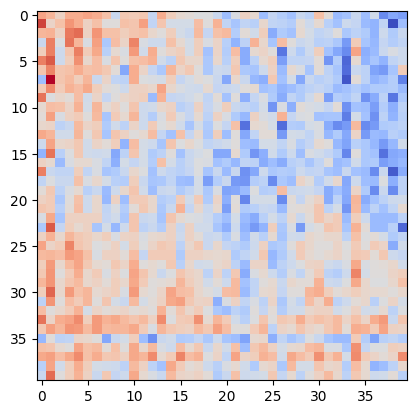

In [ ]:
plt.imshow(np.array(lst)[2000:2040,2000:2040], cmap = 'coolwarm')

In [ ]:
import contextily as cx

In [ ]:
ireland = cx.Place("Barcelona") #, source=nightlights)

<AxesSubplot:title={'center':'Barcelona, Barcelonès, Barcelona, Catalunya, 08001, España'}, xlabel='X', ylabel='Y'>

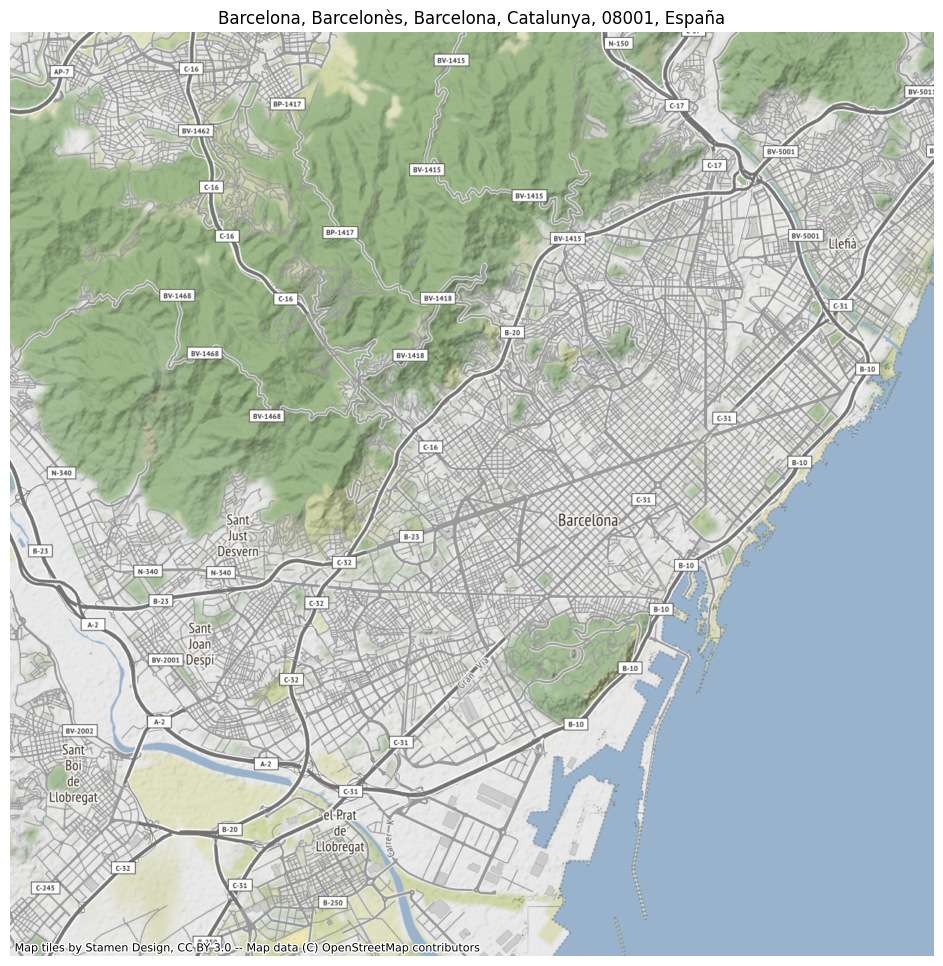

In [ ]:
ireland.plot()

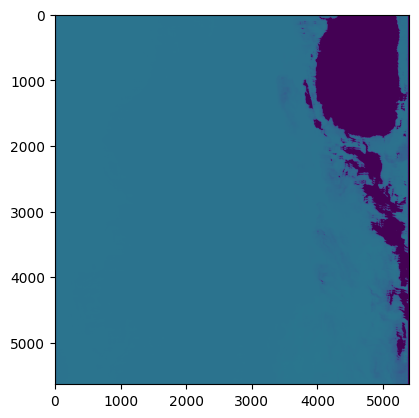

In [ ]:
plt.imshow(lst)

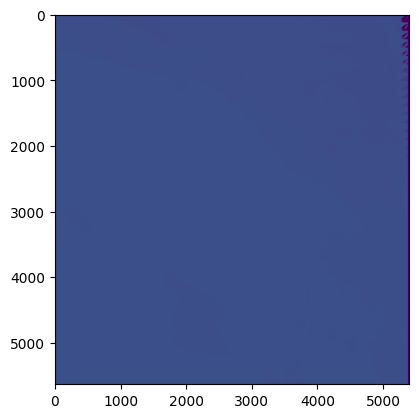

In [ ]:
plt.imshow(lst2)